In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [2]:
pbp = pd.read_csv('../../Data/play-by-play/pbp_exp12.csv')

In [ ]:
# List of categorical columns
categorical_cols = [
    'OffenseTeam', 'DefenseTeam', 'play_type', 'side_of_field', 'stadium', 
    'play_type_nfl', 'roof', 'surface_type', 'home_team', 'away_team', 
    'season_type', 'offense_formation', 'temperature_grade', 'temperature_bucket'
]

# Dictionary to hold LabelEncoders for each column
label_encoders = {}

# Apply LabelEncoder to each categorical column and store encoders
for col in categorical_cols:
    le = LabelEncoder()
    pbp[col] = le.fit_transform(pbp[col].astype(str))  # Ensure the column is treated as a string
    label_encoders[col] = le 

Confusion Matrix for fold 1:
[[1124  495]
 [ 635  984]]


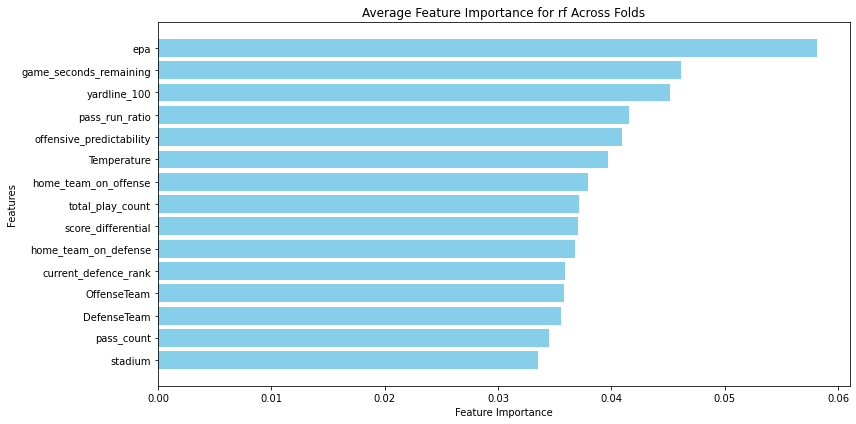

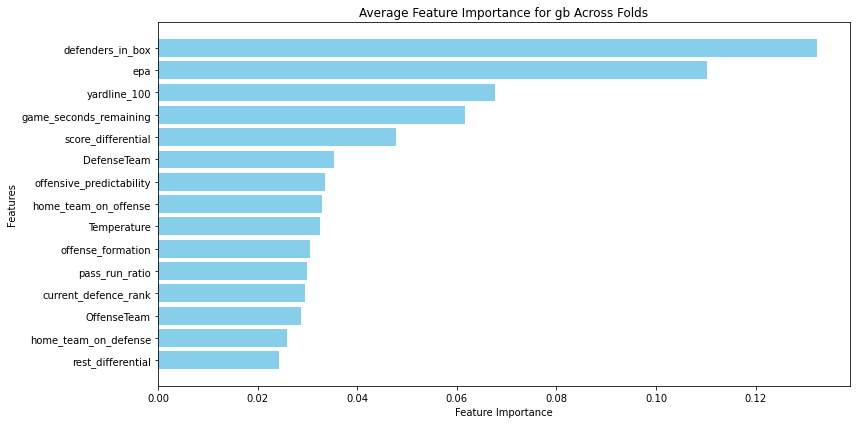

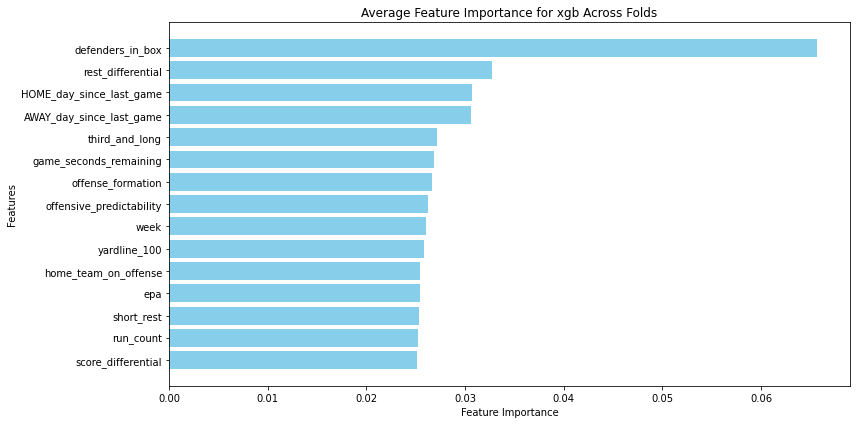

Mean Accuracy: 0.5584 ± 0.0483
Mean Precision: 0.5781 ± 0.0642
Recall scores for each fold: [0.42927733168622606, 0.6077825818406424, 0.291537986411365, 0.2452130945027795, 0.40827671402100063, 0.42124768375540456, 0.22297714638665844, 0.47869054972205066, 0.3168622606547251, 0.37801111797405806, 0.506485484867202, 0.37492279184681904, 0.291537986411365, 0.3922174181593576, 0.44533662754786907, 0.39345274861025326, 0.3143915997529339, 0.21309450277949352, 0.612106238418777, 0.3119209388511427, 0.3687461395923409, 0.46077825818406426, 0.2025941939468808, 0.40333539221741815, 0.5237801111797405, 0.34898085237801113, 0.29771463866584313, 0.27609635577516983, 0.3458925262507721, 0.4255713403335392, 0.4002470660901791, 0.36689314391599753, 0.3650401482396541, 0.46201358863495984, 0.4385423100679432, 0.4249536751080914, 0.45460160592958615, 0.37183446571958, 0.5243977764051884, 0.4076590487955528, 0.4095120444718962, 0.38727609635577515, 0.5861642989499691, 0.36751080914144535, 0.41260037059

In [ ]:
X = pbp[['week', 'OffenseTeam', 'DefenseTeam', 'Down', 'YardsToGo', 'yardline_100', 'play_type',
               'Quarter', 'game_seconds_remaining', 'game_half', 'drive', 'series', 'score_differential',
               'stadium', 'roof', 'surface_type', 'HOME_day_since_last_game', 'AWAY_day_since_last_game',
               'total_play_count', 'home_team_on_offense', 'home_team_on_defense', 'season_progression',
               'defenders_in_box', 'offense_formation', 'Temperature', 'Precipitation', 'goal_line_situation',
               'pass_count', 'run_count', 'current_defence_rank','temperature_grade', 'temperature_bucket', 'epa', 
               'late_season','is_close_game', 'is_bad_weather', 'poor_field_condition', 'rest_differential', 'blitz_situation',
               'short_rest','pass_run_ratio', 'offensive_predictability', 'fourth_down_attempt', 'third_and_long']]


y = pbp['Player-Injured-On-Play']

# Define base models and meta-model
base_models = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42)),
    ('xgb', xgb.XGBClassifier(random_state=42))
]
meta_model = LogisticRegression(random_state=42)

# Define Stratified K-Fold
k = 53  # Number of splits
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

accuracy_scores = []
precision_scores = []
recall_scores = [] 
feature_importances = {model_name: np.zeros(X.shape[1]) for model_name, _ in base_models}

# Perform stratified K-Fold cross-validation
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Handle class imbalance as in your code
    X_train_pos = X_train[y_train == 1]
    X_train_neg = X_train[y_train == 0]
    y_train_pos = y_train[y_train == 1]
    y_train_neg = y_train[y_train == 0]

    X_test_pos = X_test[y_test == 1]
    X_test_neg = X_test[y_test == 0]
    y_test_pos = y_test[y_test == 1]
    y_test_neg = y_test[y_test == 0]

    # Resample to ensure balance
    X_train_pos_resampled, y_train_pos_resampled = resample(X_train_pos, y_train_pos, replace=True, n_samples=1619, random_state=42)
    X_train_neg_resampled, y_train_neg_resampled = resample(X_train_neg, y_train_neg, replace=False, n_samples=1619, random_state=42)

    X_test_pos_resampled, y_test_pos_resampled = resample(X_test_pos, y_test_pos, replace=True, n_samples=1619, random_state=42)
    X_test_neg_resampled, y_test_neg_resampled = resample(X_test_neg, y_test_neg, replace=False, n_samples=1619, random_state=42)

    # Combine resampled data
    X_train_resampled = pd.concat([X_train_pos_resampled, X_train_neg_resampled])
    y_train_resampled = pd.concat([y_train_pos_resampled, y_train_neg_resampled])

    X_test_resampled = pd.concat([X_test_pos_resampled, X_test_neg_resampled])
    y_test_resampled = pd.concat([y_test_pos_resampled, y_test_neg_resampled])
    
    # Generate base model predictions for meta-model training
    meta_train = np.zeros((X_train_resampled.shape[0], len(base_models)))
    meta_test = np.zeros((X_test_resampled.shape[0], len(base_models)))
    
    # Train base models and create meta-features
    for i, (model_name, model) in enumerate(base_models):
        model.fit(X_train_resampled, y_train_resampled)
        meta_train[:, i] = model.predict_proba(X_train_resampled)[:, 1]
        meta_test[:, i] = model.predict_proba(X_test_resampled)[:, 1]
        
        # Store feature importances if available
        if hasattr(model, 'feature_importances_'):
            feature_importances[model_name] += model.feature_importances_
    
    # Train meta-model on base model predictions
    meta_model.fit(meta_train, y_train_resampled)
    
    # Final prediction using stacked model
    final_predictions = meta_model.predict(meta_test)
    
    # Evaluate stacked model
    accuracy = accuracy_score(y_test_resampled, final_predictions)
    precision = precision_score(y_test_resampled, final_predictions)
    recall = recall_score(y_test_resampled, final_predictions)
    
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    
    # Get confusion matrix for a specific fold
    if fold == 1: 
        cm = confusion_matrix(y_test_resampled, final_predictions)
        print(f'Confusion Matrix for fold {fold}:')
        print(cm)

# Normalize feature importances
for model_name in feature_importances:
    feature_importances[model_name] /= k

# Plot feature importances for each base model
for model_name, importances in feature_importances.items():
    sorted_indices = np.argsort(importances)[::-1]
    sorted_features = X.columns[sorted_indices]
    sorted_importances = importances[sorted_indices]
    
    plt.figure(figsize=(12, 6), facecolor='white')
    plt.barh(sorted_features[:15], sorted_importances[:15], color='skyblue')  # Top 15 features
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.title(f'Average Feature Importance for {model_name} Across Folds')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Print cross-validation results
print(f'Mean Accuracy: {np.mean(accuracy_scores):.4f} ± {np.std(accuracy_scores):.4f}')
print(f'Mean Precision: {np.mean(precision_scores):.4f} ± {np.std(precision_scores):.4f}')

print(f'Recall scores for each fold: {recall_scores}')
print(f'Mean Recall: {np.mean(recall_scores):.4f}')
print(f'Standard Deviation: {np.std(recall_scores):.4f}')